In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Functions

In [23]:
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)

    # x-data for the ECDF: x
    x = np.sort(data)

    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n

    return x, y

In [25]:
def bootstrap_replicate_1d(data, func):
    """Generate bootstrap replicate of 1D data."""
    bs_sample = np.random.choice(data, len(data))
    return func(bs_sample)

In [26]:
def draw_bs_reps(data, func, size=1):
    """Draw bootstrap replicates."""

    # Initialize array of replicates: bs_replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data,func)

    return bs_replicates

In [35]:
def draw_bs_pairs_linreg(x, y, size=1):
    """Perform pairs bootstrap for linear regression."""

    # Set up array of indices to sample from: inds
    inds = np.arange(len(x))

    # Initialize replicates: bs_slope_reps, bs_intercept_reps
    bs_slope_reps = np.empty(size)
    bs_intercept_reps = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, size=len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_slope_reps[i], bs_intercept_reps[i] = np.polyfit(bs_x, bs_y,1)

    return bs_slope_reps, bs_intercept_reps

In [ ]:
def draw_bs_pairs(x, y, func, size=1):
    """Perform pairs bootstrap for single statistic."""

    # Set up array of indices to sample from
    inds = np.arange(len(x))

    # Initialize replicates
    bs_replicates = np.empty(size)

    # Generate replicates
    for i in range(size):
        bs_inds = np.random.choice(inds, len(inds))
        bs_x, bs_y = x[bs_inds], y[bs_inds]
        bs_replicates[i] = func(bs_x, bs_y)

    return bs_replicates

## File Injestion

In [3]:
file1 = 'https://assets.datacamp.com/production/repositories/470/datasets/eb228490f7d823bfa6458b93db075ca5ccd3ec3d/finch_beaks_1975.csv'

In [4]:
file2 = 'https://assets.datacamp.com/production/repositories/470/datasets/b28d5bf65e38460dca7b3c5c0e4d53bdfc1eb905/finch_beaks_2012.csv'

In [5]:
finch_beaks_1975 = pd.read_csv(file1)

In [6]:
finch_beaks_2012 = pd.read_csv(file2)

In [7]:
finch_beaks_1975_df = pd.DataFrame(finch_beaks_1975)
finch_beaks_2012_df = pd.DataFrame(finch_beaks_2012)

In [8]:
finch_beaks_1975_gb = finch_beaks_1975_df.groupby(finch_beaks_1975_df['species'])
finch_beaks_1975_scandens = finch_beaks_1975_gb.get_group('scandens').reset_index(drop=True)

finch_beaks_2012_gb = finch_beaks_2012_df.groupby(finch_beaks_2012_df['species'])
finch_beaks_2012_scandens = finch_beaks_2012_gb.get_group('scandens').reset_index(drop=True)

In [9]:
finch_beaks_2012_scandens['Year'] = 2012
finch_beaks_1975_scandens['Year'] = 1975

In [10]:
finch_beaks_2012_scandens['Beak depth, mm'] = finch_beaks_2012_scandens['bdepth']

In [11]:
scandens_beak_depth = pd.concat([finch_beaks_1975_scandens[['Beak depth, mm','Year']], finch_beaks_2012_scandens[['Beak depth, mm','Year']]], axis = 0).reset_index(drop=True)

In [17]:
len(scandens_beak_depth)

214

## EDA BEAK DEPTHS

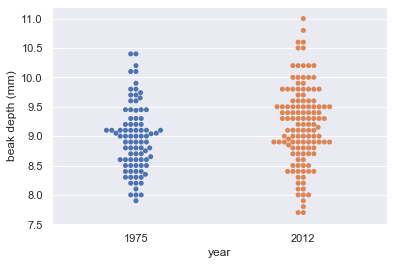

In [16]:
sns.set()
# Create bee swarm plot
_ = sns.swarmplot(x = 'Year', y = 'Beak depth, mm', data = scandens_beak_depth)

# Label the axes
_ = plt.xlabel('year')
_ = plt.ylabel('beak depth (mm)')

# Show the plot
plt.show()

There is no clear difference between the 1975 and 2012 data set. It seems as though the mean of the 2012 data set might be slightly higher, and it might have a bigger variance.

## ECDF OF BEAK DEPTHS

In [19]:
finch_beaks_1975_scandens.columns

Index(['band', 'species', 'Beak length, mm', 'Beak depth, mm', 'Year'], dtype='object')

In [33]:
bd_1975 = finch_beaks_1975_scandens.iloc[:,3].values
bd_2012 = finch_beaks_2012_scandens.iloc[:,3].values
bl_1975 = finch_beaks_1975_scandens.iloc[:,2].values
bl_2012 = finch_beaks_2012_scandens.iloc[:,2].values

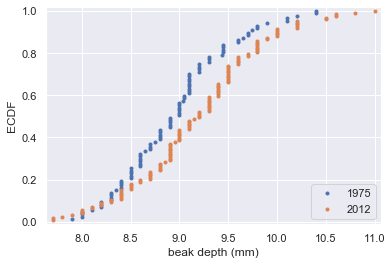

In [24]:
# Compute ECDFs
x_1975, y_1975 = ecdf(bd_1975)
x_2012, y_2012 = ecdf(bd_2012)

# Plot the ECDFs
_ = plt.plot(x_1975, y_1975, marker='.', linestyle='none')
_ = plt.plot(x_2012, y_2012, marker='.', linestyle='none')

# Set margins
plt.margins(0.02)

# Add axis labels and legend
_ = plt.xlabel('beak depth (mm)')
_ = plt.ylabel('ECDF')
_ = plt.legend(('1975', '2012'), loc='lower right')

# Show the plot
plt.show()

The differences are much clearer in the ECDF. The mean is larger in the 2012 data, and the variance does appear larger as well.

## Parameter estimates of beak depths

In [28]:
# Compute the difference of the sample means: mean_diff
mean_diff = np.mean(bd_2012) - np.mean(bd_1975)

# Get bootstrap replicates of means
bs_replicates_1975 = draw_bs_reps(bd_1975,np.mean,10000)
bs_replicates_2012 = draw_bs_reps(bd_2012,np.mean,10000)

# Compute samples of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

# Compute 95% confidence interval: conf_int
conf_int = np.percentile(bs_diff_replicates,[2.5,97.5])

# Print the results
print('difference of means =', mean_diff, 'mm')
print('95% confidence interval =', conf_int, 'mm')

difference of means = 0.22622047244094645 mm
95% confidence interval = [0.05920147 0.39069905] mm


## Hypothesis test: Are beaks deeper in 2012?

The hypothesis we are testing is not that the beak depths come from the same distribution. For that we could use a permutation test. The null hypothesis is that the means are equal. If p is small then we reject the null hypothesis.

In [29]:
# Compute mean of combined data set: combined_mean
combined_mean = np.mean(np.concatenate((bd_1975, bd_2012)))

# Shift the samples
bd_1975_shifted = bd_1975 - np.mean(bd_1975) + combined_mean
bd_2012_shifted = bd_2012 - np.mean(bd_2012) + combined_mean

# Get bootstrap replicates of shifted data sets
bs_replicates_1975 = draw_bs_reps(bd_1975_shifted,np.mean,10000)
bs_replicates_2012 = draw_bs_reps(bd_2012_shifted,np.mean,10000)

# Compute replicates of difference of means: bs_diff_replicates
bs_diff_replicates = bs_replicates_2012 - bs_replicates_1975

# Compute the p-value
p = np.sum(bs_diff_replicates >= mean_diff) / len(bs_diff_replicates)

# Print p-value
print('p =', p)

p = 0.0036


low p value means there is statistically significant difference in mean depths of the birds in 40 years. 

## What is the relationship between beak depth change vs beak length change?

In [31]:
bl_1975

array([13.9 , 14.  , 12.9 , 13.5 , 12.9 , 14.6 , 13.  , 14.2 , 14.  ,
       14.2 , 13.1 , 15.1 , 13.5 , 14.4 , 14.9 , 12.9 , 13.  , 14.9 ,
       14.  , 13.8 , 13.  , 14.75, 13.7 , 13.8 , 14.  , 14.6 , 15.2 ,
       13.5 , 15.1 , 15.  , 12.8 , 14.9 , 15.3 , 13.4 , 14.2 , 15.1 ,
       15.1 , 14.  , 13.6 , 14.  , 14.  , 13.9 , 14.  , 14.9 , 15.6 ,
       13.8 , 14.4 , 12.8 , 14.2 , 13.4 , 14.  , 14.8 , 14.2 , 13.5 ,
       13.4 , 14.6 , 13.5 , 13.7 , 13.9 , 13.1 , 13.4 , 13.8 , 13.6 ,
       14.  , 13.5 , 12.8 , 14.  , 13.4 , 14.9 , 15.54, 14.63, 14.73,
       15.73, 14.83, 15.94, 15.14, 14.23, 14.15, 14.35, 14.95, 13.95,
       14.05, 14.55, 14.05, 14.45, 15.05, 13.25])

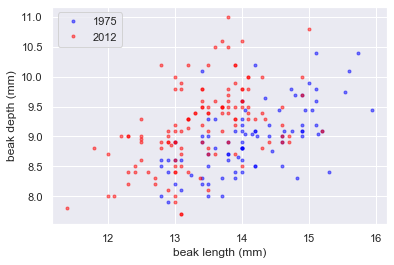

In [34]:
# Make scatter plot of 1975 data
_ = plt.plot(bl_1975, bd_1975, marker='.',
             linestyle='None', color='blue', alpha=0.5)

# Make scatter plot of 2012 data
_ = plt.plot(bl_2012, bd_2012, marker='.',
             linestyle='None', color='red', alpha=0.5)

# Label axes and make legend
_ = plt.xlabel('beak length (mm)')
_ = plt.ylabel('beak depth (mm)')
_ = plt.legend(('1975', '2012'), loc='upper left')

# Show the plot
plt.show()

Eyeballing this: In looking at the plot, we see that beaks got deeper (the red points are higher up in the y-direction), but not really longer. If anything, they got a bit shorter, since the red dots are to the left of the blue dots. So, it does not look like the beaks kept the same shape; they became shorter and deeper.

## Linear regressions

In [36]:
# Compute the linear regressions
slope_1975, intercept_1975 = np.polyfit(bl_1975, bd_1975, 1)
slope_2012, intercept_2012 = np.polyfit(bl_2012, bd_2012, 1)

# Perform pairs bootstrap for the linear regressions
bs_slope_reps_1975, bs_intercept_reps_1975 = \
        draw_bs_pairs_linreg(bl_1975, bd_1975, 1000)
bs_slope_reps_2012, bs_intercept_reps_2012 = \
        draw_bs_pairs_linreg(bl_2012, bd_2012, 1000)

# Compute confidence intervals of slopes
slope_conf_int_1975 = np.percentile(bs_slope_reps_1975, [2.5, 97.5])
slope_conf_int_2012 = np.percentile(bs_slope_reps_2012, [2.5, 97.5])
intercept_conf_int_1975 = np.percentile(
                            bs_intercept_reps_1975, [2.5, 97.5])
intercept_conf_int_2012 = np.percentile(
                            bs_intercept_reps_2012, [2.5, 97.5])

# Print the results
print('1975: slope =', slope_1975,
      'conf int =', slope_conf_int_1975)
print('1975: intercept =', intercept_1975,
      'conf int =', intercept_conf_int_1975)
print('2012: slope =', slope_2012,
      'conf int =', slope_conf_int_2012)
print('2012: intercept =', intercept_2012,
      'conf int =', intercept_conf_int_2012)

1975: slope = 0.4652051691605937 conf int = [0.32824771 0.59494608]
1975: intercept = 2.3908752365842267 conf int = [0.56809678 4.35346502]
2012: slope = 0.462630358835313 conf int = [0.33495714 0.60470796]
2012: intercept = 2.9772474982360198 conf int = [1.09588584 4.68066197]


It looks like they have the same slope, but different intercepts.

## Visualizing Linear Regression Results

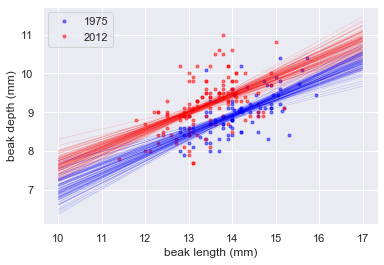

In [38]:
# Make scatter plot of 1975 data
_ = plt.plot(bl_1975, bd_1975, marker='.',
             linestyle='none', color='blue', alpha=0.5)

# Make scatter plot of 2012 data
_ = plt.plot(bl_2012, bd_2012, marker='.',
             linestyle='none', color='red', alpha=0.5)

# Label axes and make legend
_ = plt.xlabel('beak length (mm)')
_ = plt.ylabel('beak depth (mm)')
_ = plt.legend(('1975', '2012'), loc='upper left')

# Generate x-values for bootstrap lines: x
x = np.array([10, 17])

# Plot the bootstrap lines
for i in range(1000):
    plt.plot(x, bs_slope_reps_1975[i] * x + bs_intercept_reps_1975[i],
             linewidth=0.5, alpha=0.2, color='blue')
    plt.plot(x, bs_slope_reps_2012[i] * x + bs_intercept_reps_2012[i],
             linewidth=0.5, alpha=0.2, color='red')

# Draw the plot again
plt.show()

## Beak length to depth ratio

In [39]:
# Compute length-to-depth ratios
ratio_1975 = bl_1975 / bd_1975
ratio_2012 = bl_2012 / bd_2012

# Compute means
mean_ratio_1975 = np.mean(ratio_1975)
mean_ratio_2012 = np.mean(ratio_2012)

# Generate bootstrap replicates of the means
bs_replicates_1975 = draw_bs_reps(ratio_1975, np.mean, size=10000)
bs_replicates_2012 = draw_bs_reps(ratio_2012, np.mean, size=10000)

# Compute the 99% confidence intervals
conf_int_1975 = np.percentile(bs_replicates_1975, [0.5, 99.5])
conf_int_2012 = np.percentile(bs_replicates_2012, [0.5, 99.5])

# Print the results
print('1975: mean ratio =', mean_ratio_1975,
      'conf int =', conf_int_1975)
print('2012: mean ratio =', mean_ratio_2012,
      'conf int =', conf_int_2012)


1975: mean ratio = 1.5788823771858533 conf int = [1.55709896 1.60159689]
2012: mean ratio = 1.4658342276847767 conf int = [1.44445286 1.48782031]


More: https://campus.datacamp.com/courses/statistical-thinking-in-python-part-2/putting-it-all-together-a-case-study?ex=13